# Line Segmentation in Historical Document

## 0. Imports

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

## 1. Document Image Preprocessing

### 1.1 Data Loading and Exploration

Dimension: (411, 251)
Pixel value range: [28, 190]


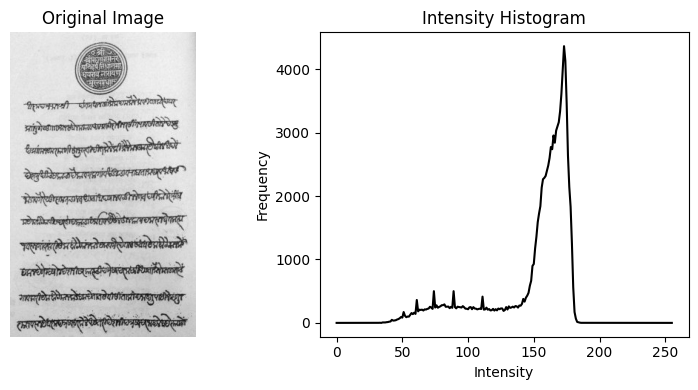

In [2]:
def load_document_image(image_path):
    """ Loads the historical document image and prints image characteristics. """

    image = cv2.imread(image_path, 0)
    hist = np.bincount(image.ravel(), minlength=256)

    print(f'Dimension: {image.shape}')
    print(f'Pixel value range: [{image.min()}, {image.max()}]')

    fig, axs = plt.subplots(1, 2, figsize=(8, 4))

    axs[0].imshow(image, cmap='gray')
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].plot(hist, c='k')
    axs[1].set_ylabel('Frequency')
    axs[1].set_xlabel('Intensity')
    axs[1].set_title('Intensity Histogram')

    plt.tight_layout()
    plt.savefig('load_document_image.png', bbox_inches='tight')
    plt.show()

    return image

image = load_document_image('../data/historical-doc.png')

### 1.2 Image Preprocessing for Text Line Detection

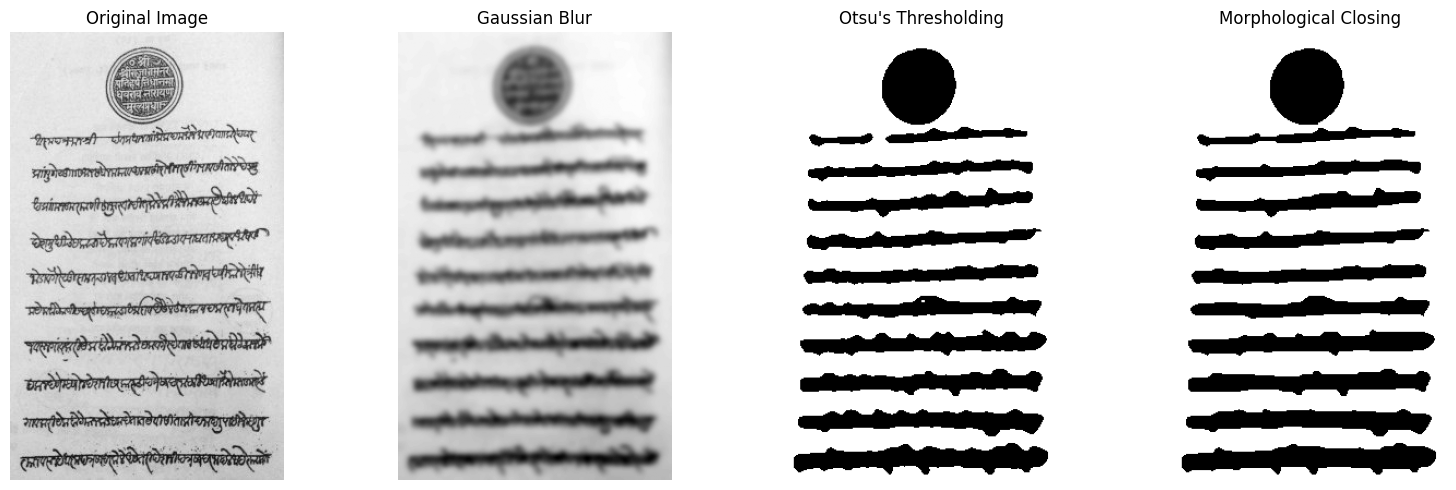

In [3]:
def preprocess_image(image):
    """ Preprocessing for line detection in the historical document image. """

    blurred = cv2.GaussianBlur(image, (15, 15), 0)
    _, binary = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    closed = cv2.morphologyEx(binary, cv2.MORPH_OPEN, np.ones((5, 15), np.uint8))

    fig, axes = plt.subplots(1, 4, figsize=(16, 5))

    axes[0].imshow(image, cmap='gray')
    axes[0].set_title('Original Image')
    axes[0].axis('off')

    axes[1].imshow(blurred, cmap='gray')
    axes[1].set_title('Gaussian Blur')
    axes[1].axis('off')

    axes[2].imshow(binary, cmap='gray')
    axes[2].set_title('Otsu\'s Thresholding')
    axes[2].axis('off')

    axes[3].imshow(closed, cmap='gray')
    axes[3].set_title('Morphological Closing')
    axes[3].axis('off')

    plt.tight_layout()
    plt.savefig('preprocess_image.png', bbox_inches='tight')
    plt.show()

    return closed

preprocessed_image = preprocess_image(image)

**Comments:** 

- Gaussian Blur: Removes noise (e.g. above the last line in the image) and irrelevant features (e.g. the circular artifact around the end of sixth line).

- Otsu's Thresholding: Segments the background (paper) from the foreground (text and seal) amidst lighting variation and excess blurring. Removes the noise leftover after Gaussian blur.

- Morphological Closing: Connects broken shapes while retaining similar size. Helps prevent double counting in the subsequent sections.

## 2. Text Line Detection and Segmentation

### 2.1 Rectangular Bounding Box Detection

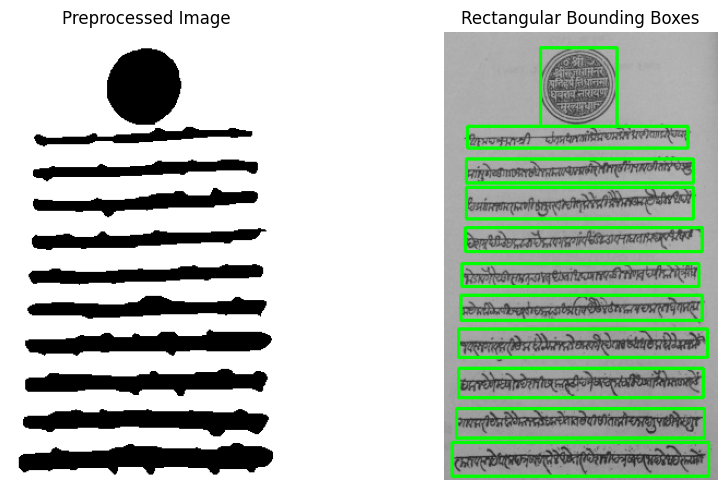

In [4]:
def detect_lines_with_bboxes(image, preprocessed_image):
    """ Detects text lines and encloses each with a rectangular bounding box. """

    output = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    contours, _ = cv2.findContours(preprocessed_image, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    index = 0
    bounding_boxes = []
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        if x == 0 and y == 0 and w == image.shape[1] and h == image.shape[0]:
            continue
        index += 1
        cv2.imwrite(f'line_{index}.png', image[y:y+h, x:x+w])
        cv2.rectangle(output, (x, y), (x+w, y+h), (0, 255, 0), 2)

    cv2.imwrite('historical_doc_bounding_box.png', output)

    fig, axs = plt.subplots(1, 2, figsize=(10, 5))

    axs[0].imshow(preprocessed_image, cmap='gray')
    axs[0].set_title('Preprocessed Image')
    axs[0].axis('off')

    axs[1].imshow(output)
    axs[1].set_title('Rectangular Bounding Boxes')
    axs[1].axis('off')

    plt.tight_layout()
    plt.savefig('detect_lines_with_bboxes.png', bbox_inches='tight')
    plt.show()

detect_lines_with_bboxes(image, preprocessed_image)

**Comments:**

- The method performs well owing to the well segmented input.

- During experimentation, it was however noticed that this approach fails when the lines are not well separated (e.g. the text in seal which is closely knit).

- Alternate approach of connected components was found to be more robust (used in subsequent sections).

### 2.2 Line Segmentation within the Circular Region

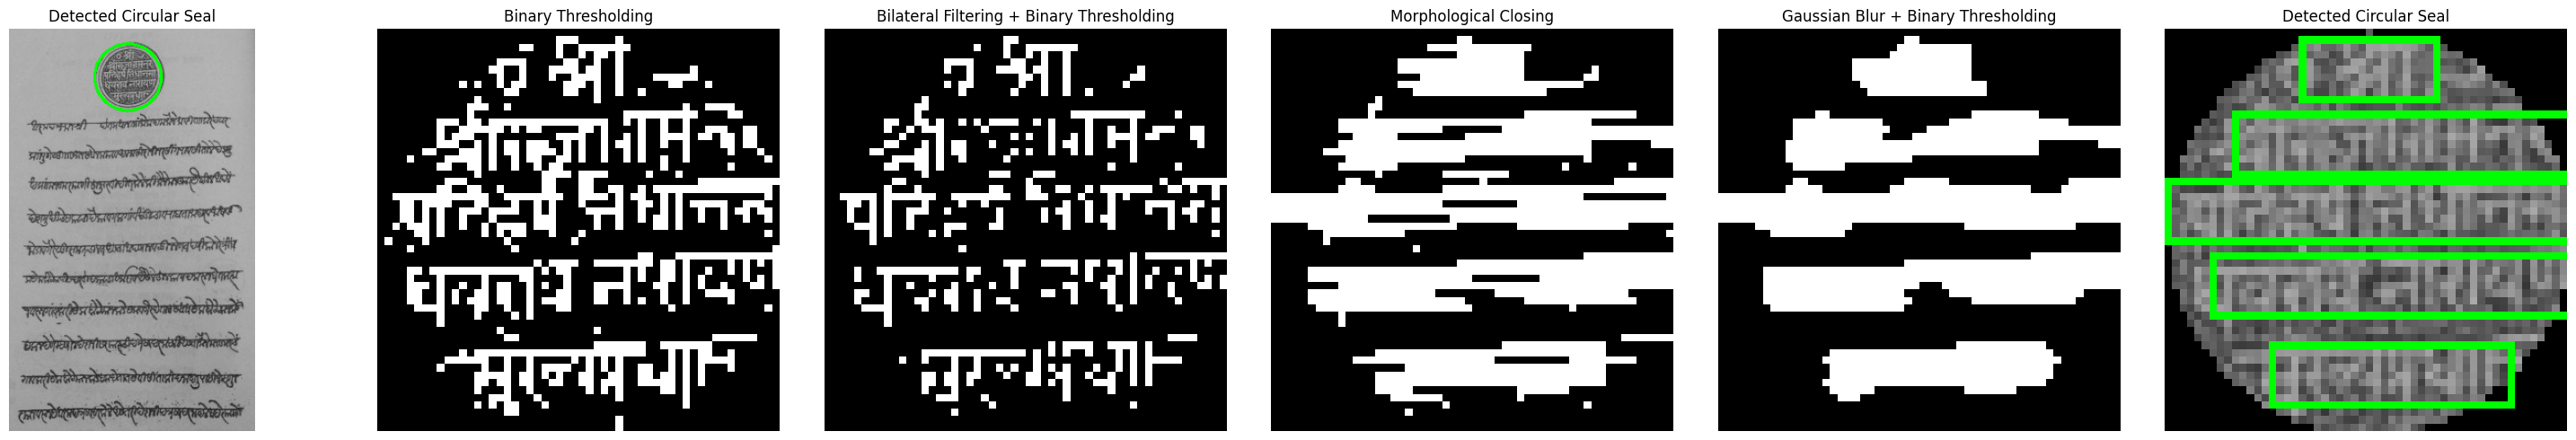

In [5]:
def segment_lines_in_seal(image, preprocessed_image):
    """ Detects text lines within the circular seal. """

    output = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    circles = cv2.HoughCircles(preprocessed_image, cv2.HOUGH_GRADIENT, dp=2, minDist=10,
                                param1=10, param2=35, minRadius=15, maxRadius=35)

    if circles is not None:
        circles = np.round(circles[0, :]).astype("int")
        for (x, y, r) in circles:
            cv2.circle(output, (x, y), r, (0, 255, 0), 2)

        x, y, r = circles[0]
        r -= 7
        x1, x2 = x - r, x + r
        y1, y2 = y - r, y + r

        mask = np.zeros_like(image, dtype=np.uint8)
        cv2.circle(mask, (x, y), r, (255, 255, 255), -1)
        masked_image = cv2.bitwise_and(image, mask)
        masked_image = masked_image[y1:y2, x1:x2]
        _, thresholded = cv2.threshold(masked_image, 127, 255, cv2.THRESH_BINARY)

        blurred = cv2.bilateralFilter(thresholded, d=9, sigmaColor=350, sigmaSpace=0)
        _, blurred = cv2.threshold(masked_image, 140, 255, cv2.THRESH_BINARY)
        closed = cv2.morphologyEx(blurred, cv2.MORPH_CLOSE, np.ones((1, 8), np.uint8))
        closed_blurred = cv2.GaussianBlur(closed, (5, 5), 0)
        _, closed_blurred = cv2.threshold(closed_blurred, 140, 255, cv2.THRESH_BINARY)

        final_output = cv2.cvtColor(masked_image, cv2.COLOR_GRAY2RGB)
        num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(closed_blurred, connectivity=8)

        index = 0
        for i in range(1, num_labels):
            x, y, w, h, area = stats[i]
            index += 1
            cv2.imwrite(f'circle_line_{index}.png', masked_image[y:y+h, x:x+w])
            cv2.rectangle(final_output, (x, y), (x + w, y + h), (0, 255, 0), 1)

    cv2.imwrite('historical_doc_circular_seal.png', masked_image)
    cv2.imwrite('historical_doc_circular_seal_bounding_box.png', final_output)

    fig, axs = plt.subplots(1, 6, figsize=(30, 5))

    axs[0].imshow(output)
    axs[0].set_title('Detected Circular Seal')
    axs[0].axis('off')

    axs[1].imshow(thresholded, cmap='gray')
    axs[1].set_title('Binary Thresholding')
    axs[1].axis('off')

    axs[2].imshow(blurred, cmap='gray')
    axs[2].set_title('Bilateral Filtering + Binary Thresholding')
    axs[2].axis('off')

    axs[3].imshow(closed, cmap='gray')
    axs[3].set_title('Morphological Closing')
    axs[3].axis('off')

    axs[4].imshow(closed_blurred, cmap='gray')
    axs[4].set_title('Gaussian Blur + Binary Thresholding')
    axs[4].axis('off')

    axs[5].imshow(final_output)
    axs[5].set_title('Detected Circular Seal')
    axs[5].axis('off')

    plt.tight_layout()
    plt.savefig('segment_lines_in_seal.png', bbox_inches='tight')
    plt.show()

    return masked_image, closed_blurred

masked_seal, seal_closed = segment_lines_in_seal(image, preprocessed_image)

**Comments:**

- The text in the seal has very small line spacing. Consequently, detecting lines using morphological operations is not trivial.

- However, assuming all lines are horizontal. We can use a wide structuring element that avoids confusing between the vertically separated nearby lines.

- Thus, we can apply the logic from image preprocessing to preprocess the cropped portion of the seal (to get the fifth image in the plot).

- Lastly, we find the connected components and draw a rectangle spanning the component's minimum and maximum {x, y} values.

## 3. Tighter Polygonal Boundary Detection

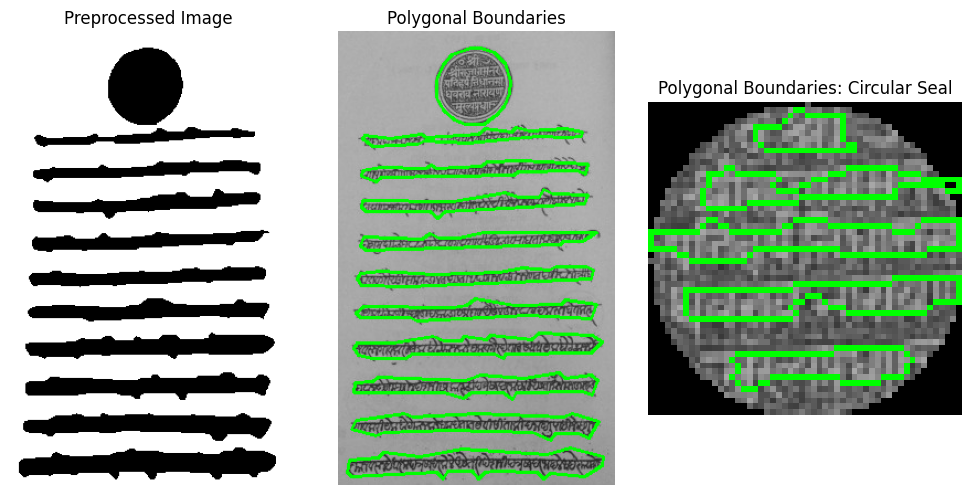

In [6]:
def detect_lines_with_polygons(image, preprocessed_image, masked_seal, seal_closed):
    """ Detects tight polygonal boundary around each text line. """

    output = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)
    output_seal = cv2.cvtColor(masked_seal, cv2.COLOR_GRAY2RGB)

    contours, _ = cv2.findContours(255 - preprocessed_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours_seal, _ = cv2.findContours(seal_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        polygon = cv2.approxPolyDP(contour, 0.005 * cv2.arcLength(contour, True), True)
        cv2.polylines(output, [polygon], True, (0, 255, 0), 2)

    for contour in contours_seal:
        polygon = cv2.approxPolyDP(contour, 0.0001 * cv2.arcLength(contour, True), True)
        cv2.polylines(output_seal, [polygon], True, (0, 255, 0), 1)

    cv2.imwrite('historical_doc_polygonal_boundary.png', output)
    cv2.imwrite('historical_doc_circular_seal_polygonal_boundary.png', output_seal)

    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    axs[0].imshow(preprocessed_image, cmap='gray')
    axs[0].set_title('Preprocessed Image')
    axs[0].axis('off')

    axs[1].imshow(output)
    axs[1].set_title('Polygonal Boundaries')
    axs[1].axis('off')

    axs[2].imshow(output_seal)
    axs[2].set_title('Polygonal Boundaries: Circular Seal')
    axs[2].axis('off')

    plt.tight_layout()
    plt.savefig('detect_lines_with_polygons.png', bbox_inches='tight')
    plt.show()

detect_lines_with_polygons(image, preprocessed_image, masked_seal, seal_closed)

**Comments:**

- The polygonal boundaries are more precise (e.g. the circular seal is approximated well), but they suffer from some loss of detail due to blurring in the preprocessing stage.

![polygonal boundary](historical_doc_polygonal_boundary.png)
![bounding box](historical_doc_bounding_box.png)

- Polygons are more precise and pay more attention to the foreground. It would be better if their boundaries could follow each stroke, thus separating the foreground from the background, but that may not possible due to presence of loops.

- The resultant complex polygonal boundaries may not be immediately useful. Bounding boxes, for example, can be directly used for cropping. An equivalent for polygonal boundaries would require an additional bounding box on top, besides need for masking the new pixels with a "don't care" value.

- The complex polygonal boundary still incur some error while fitting the curve. An acceptable threshold for this error needs to be specified manually, which impacts both accuracy and complexity of the operation.